In [4]:
!pip install python-Levenshtein

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import Levenshtein

In [6]:
df = pd.read_csv('AptaBench_dataset_v2.csv')

print('Ознакомление с датасетом:')

print(f'Всего {len(df)} аптамеров')
print(f'Всего {df['sequence'].nunique()} уникальных последовательностей')
print(f'Всего {df['canonical_smiles'].nunique()} уникальных мишеней')
print(f'Список колонок: {df.columns}')

Ознакомление с датасетом:
Всего 6413 аптамеров
Всего 1686 уникальных последовательностей
Всего 1041 уникальных мишеней
Список колонок: Index(['type', 'sequence', 'canonical_smiles', 'pKd_value', 'label', 'buffer',
       'origin', 'source'],
      dtype='object')


In [7]:
print(df.info())

# Почистим от дубликатов:

df_clean = df.drop_duplicates(subset=['sequence', 'canonical_smiles']).reset_index(drop=True)

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              6413 non-null   object 
 1   sequence          6413 non-null   object 
 2   canonical_smiles  6413 non-null   object 
 3   pKd_value         2223 non-null   float64
 4   label             6413 non-null   int64  
 5   buffer            4632 non-null   object 
 6   origin            5062 non-null   object 
 7   source            6413 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 400.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6233 entries, 0 to 6232
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              6233 non-null   object 
 1   sequence          6233 non-null   object 
 2   canonical_smiles  6233 non-null   object 
 3   pKd_value

**В датасете находится:**

1) Столбец `type` - РНК или ДНК наш аптамер
2) Столбец `sequence` - сами аптамеры
3) Столбец `canonical_smiles` - Это химическая структура мишени, к которой специфичен аптамер.
4) Столбец `pKd_value` - Показатель афинности аптамера, есть не для всех аптамеров
5) Столбец `label` - бинарная классификация: соединяется аптамер с мишенью или нет (?)
6) Столбец `buffer` - Показатели химической среды, при которой измеряли силу связывания аптамера
7) Столбец `origin` - Статьи, источники, из которых информация о аптамере
8) Столбец `source` - Название датасетов-источников

In [8]:
# Отбор только связанных с мишенью аптамеров

df_active = df_clean[df_clean['label'] == 1].copy()

print(df_active.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3185 entries, 2 to 6214
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              3185 non-null   object 
 1   sequence          3185 non-null   object 
 2   canonical_smiles  3185 non-null   object 
 3   pKd_value         1781 non-null   float64
 4   label             3185 non-null   int64  
 5   buffer            1757 non-null   object 
 6   origin            2131 non-null   object 
 7   source            3185 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 223.9+ KB
None


In [9]:
# Убираем пустые значения pKd
df_pkd = df_active.dropna(subset=['pKd_value']).copy()

# Фильтруем по порогу (например, pKd > 6, что соответствует Kd < 1 мкМ)
threshold = 6
df_final = df_pkd[df_pkd['pKd_value'] > threshold].copy()

print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, 3 to 6205
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              872 non-null    object 
 1   sequence          872 non-null    object 
 2   canonical_smiles  872 non-null    object 
 3   pKd_value         872 non-null    float64
 4   label             872 non-null    int64  
 5   buffer            414 non-null    object 
 6   origin            469 non-null    object 
 7   source            872 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 61.3+ KB
None


In [10]:
print(f'Со сколькими мишенями связаны оставшиеся аптамеры: {df_final['canonical_smiles'].nunique()}')

df_final['seq_len'] = df_final['sequence'].str.len()
print(f'Смотрим разброс длин аптамеров:')
print(df_final['seq_len'].describe())


Со сколькими мишенями связаны оставшиеся аптамеры: 336
Смотрим разброс длин аптамеров:
count    872.000000
mean      50.000000
std       25.511259
min       12.000000
25%       33.000000
50%       46.000000
75%       64.250000
max      192.000000
Name: seq_len, dtype: float64


In [11]:
print('По итогам очистки датасета:')

print(f'Всего {len(df_final)} аптамеров')
print(f'Всего {df_final['sequence'].nunique()} уникальных последовательностей')
print(f'Всего {df_final['canonical_smiles'].nunique()} уникальных мишеней')

По итогам очистки датасета:
Всего 872 аптамеров
Всего 602 уникальных последовательностей
Всего 336 уникальных мишеней


Для повышения достоверности анализа скаффолдов была проведена фильтрация базы: удалены дубликаты аптамеров с такими же мишенями (но оставлены дубликаты аптамеров, если они специфичны для нескольких мишеней), исключены записи с низким сродством ($pKd < 6$) и отсутствующими первоисточниками и условиями среды в которой подтверждено действие аптамера.

##### После этого можно начать анализ мишеней: 

- Нужно узнать, сколько аптамеров подходят к каждой.

<Axes: >

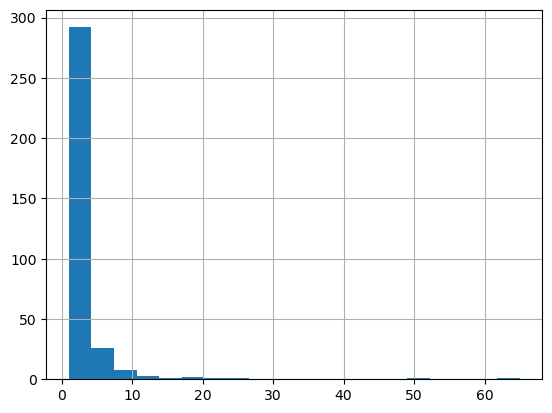

In [12]:
df_final.groupby('canonical_smiles')['sequence'].count().hist(bins=20)

In [15]:
# Создаем таблицу: мишень и сколько для неё есть аптамеров
target_table = df_final.groupby('canonical_smiles')['sequence'].count().reset_index()

target_table.columns = ['Мишень (SMILES)', 'Количество аптамеров']

# Сортируем 
target_table = target_table.sort_values(by='Количество аптамеров', ascending=False)

print(target_table.head(27))

                                       Мишень (SMILES)  Количество аптамеров
135     COC(=O)[C@@H]1C2CCC(C[C@@H]1OC(=O)c1ccccc1)N2C                    65
286                                  N[C@@H](CS)C(=O)O                    51
226  NCC1OC(OC2C(CO)OC(OC3C(O)C(N)CC(N)C3OC3OC(CN)C...                    26
46              CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1                    23
146  COc1cc2c(c3oc(=O)c4c(c13)CCC4=O)[C@]1(O)C=CO[C...                    20
140      COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O                    18
27   CC(C)[C@H](NC(=O)c1nn(Cc2ccc(F)cc2)c2ccccc12)C...                    15
42   CC1Cc2c(Cl)cc(C(=O)NC(Cc3ccccc3)C(=O)O)c(O)c2C...                    12
161  C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...                    11
268  NC[C@@H]1O[C@H](O[C@H]2[C@@H](O)[C@H](O[C@H]3O...                    11
12             CC(=O)NC1C(O)CC(O)(C(=O)O)OC1C(O)C(O)CO                     9
158  C[C@@H]1Cc2c(Cl)cc(C(=O)N[C@@H](Cc3ccccc3)C(=O...                     9